<a href="https://colab.research.google.com/github/AlbertoVentura8/AnalisisPredictivo/blob/main/MarchMad_Prediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Permiso para exportar desde Drive
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [152]:
# Voy a cargar las librerías que vamos a usar a lo largo del EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from collections import Counter
from tensorflow.keras.utils import to_categorical
from imblearn.ensemble import BalancedRandomForestClassifier
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers


In [4]:
#Hacemos la carga del dataset. Dataset previamente subido a GoogleColab.
March_Madness_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1VRodxJqhnl2IK63lmumPhLwhRDe6Y2Gu')
March_Madness_df.head()

,Unnamed: 0,Season,Team Name,Conference,Adjusted Temo,Adjusted Offensive Efficiency,Adjusted Defensive Efficiency,Avg Possession Length (Offense),Avg Possession Length (Defense),eFGPct,...,SFOR,SGOR,PGOR,CenterDR,PFDR,SFDR,SGDR,PGDR,Net Rating,Is_Champion
0,0,2015,Kentucky,Southeastern Conference (SEC),62.4,121.3,84.4,17.7,19.6,0.515116,...,20.03,5.69,6.08,27.92,30.08,18.01,13.00,10.99,36.9,No Llega
1,1,2021,Gonzaga,West Coast Conference (WCC),73.8,126.4,89.9,14.4,18.0,0.610178,...,6.54,22.61,11.41,23.99,18.56,13.28,24.63,19.49,36.5,No
2,2,2024,UConn,Big East Conference,64.6,127.5,91.1,18.6,17.5,0.569075,...,20.29,13.83,14.05,25.88,17.21,20.98,20.55,15.33,36.4,Si
3,3,2008,Kansas,Big 12 Conference,66.8,120.9,85.7,18.6,17.5,0.565912,...,22.11,5.59,5.77,26.38,28.48,18.37,13.90,12.87,35.2,Si
4,4,2019,Virginia,Atlantic Coast Conference (ACC),59.4,123.4,89.2,21.0,18.8,0.551800,...,14.67,8.82,8.61,23.45,26.61,18.51,17.84,13.59,34.2,Si


In [5]:
# Vamos a ver las variables
March_Madness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6767 entries, 0 to 6766
Data columns (total 50 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       6767 non-null   int64  
 1   Season                           6767 non-null   int64  
 2   Team Name                        6767 non-null   object 
 3   Conference                       6767 non-null   object 
 4   Adjusted Temo                    6767 non-null   float64
 5   Adjusted Offensive Efficiency    6767 non-null   float64
 6   Adjusted Defensive Efficiency    6767 non-null   float64
 7   Avg Possession Length (Offense)  6767 non-null   float64
 8   Avg Possession Length (Defense)  6767 non-null   float64
 9   eFGPct                           6767 non-null   float64
 10  TOPct                            6767 non-null   float64
 11  ORPct                            6767 non-null   float64
 12  OffFT               

In [6]:
#Eliminar columna Unnamed0
del March_Madness_df['Unnamed: 0']
March_Madness_df.head()

,Season,Team Name,Conference,Adjusted Temo,Adjusted Offensive Efficiency,Adjusted Defensive Efficiency,Avg Possession Length (Offense),Avg Possession Length (Defense),eFGPct,TOPct,...,SFOR,SGOR,PGOR,CenterDR,PFDR,SFDR,SGDR,PGDR,Net Rating,Is_Champion
0,2015,Kentucky,Southeastern Conference (SEC),62.4,121.3,84.4,17.7,19.6,0.515116,0.162529,...,20.03,5.69,6.08,27.92,30.08,18.01,13.00,10.99,36.9,No Llega
1,2021,Gonzaga,West Coast Conference (WCC),73.8,126.4,89.9,14.4,18.0,0.610178,0.161279,...,6.54,22.61,11.41,23.99,18.56,13.28,24.63,19.49,36.5,No
2,2024,UConn,Big East Conference,64.6,127.5,91.1,18.6,17.5,0.569075,0.144997,...,20.29,13.83,14.05,25.88,17.21,20.98,20.55,15.33,36.4,Si
3,2008,Kansas,Big 12 Conference,66.8,120.9,85.7,18.6,17.5,0.565912,0.191079,...,22.11,5.59,5.77,26.38,28.48,18.37,13.90,12.87,35.2,Si
4,2019,Virginia,Atlantic Coast Conference (ACC),59.4,123.4,89.2,21.0,18.8,0.551800,0.147067,...,14.67,8.82,8.61,23.45,26.61,18.51,17.84,13.59,34.2,Si


In [7]:
# Para poder usar la columna Is_Champion como variable objetivo y crear correlaciones, lo más fácil va a ser darle un valor a cada texto
# Convertir la columna 'Is_Champion' en valores numéricos, para poder ver correlaciones
March_Madness_df['Is_Champion_Num'] = March_Madness_df['Is_Champion'].map({
    'Si': 2,
    'No': 1,
    'No Llega': 0
})
March_Madness_df.head()

,Season,Team Name,Conference,Adjusted Temo,Adjusted Offensive Efficiency,Adjusted Defensive Efficiency,Avg Possession Length (Offense),Avg Possession Length (Defense),eFGPct,TOPct,...,SGOR,PGOR,CenterDR,PFDR,SFDR,SGDR,PGDR,Net Rating,Is_Champion,Is_Champion_Num
0,2015,Kentucky,Southeastern Conference (SEC),62.4,121.3,84.4,17.7,19.6,0.515116,0.162529,...,5.69,6.08,27.92,30.08,18.01,13.00,10.99,36.9,No Llega,0
1,2021,Gonzaga,West Coast Conference (WCC),73.8,126.4,89.9,14.4,18.0,0.610178,0.161279,...,22.61,11.41,23.99,18.56,13.28,24.63,19.49,36.5,No,1
2,2024,UConn,Big East Conference,64.6,127.5,91.1,18.6,17.5,0.569075,0.144997,...,13.83,14.05,25.88,17.21,20.98,20.55,15.33,36.4,Si,2
3,2008,Kansas,Big 12 Conference,66.8,120.9,85.7,18.6,17.5,0.565912,0.191079,...,5.59,5.77,26.38,28.48,18.37,13.90,12.87,35.2,Si,2
4,2019,Virginia,Atlantic Coast Conference (ACC),59.4,123.4,89.2,21.0,18.8,0.551800,0.147067,...,8.82,8.61,23.45,26.61,18.51,17.84,13.59,34.2,Si,2


In [19]:
#Comprobamos que no nos dejamos ninguna columna
columns = ['Net Rating', 'AdjEM', 'Adjusted Offensive Efficiency', 'Adjusted Defensive Efficiency', 'eFGPct', 'FG2Pct', 'FG3Pct', 'BlockPct', 'OppFG2Pct', 'OppFG3Pct', 'OppBlockPct', 'EffectiveHeight', 'PGOR', 'PGDR', 'SGOR', 'SGDR', 'SFOR', 'SFDR', 'PFOR', 'PFDR', 'CenterOR', 'CenterDR', 'Bench']

for col in columns:
    if col not in March_Madness_df.columns:
        print(f"Column {col} is missing.")

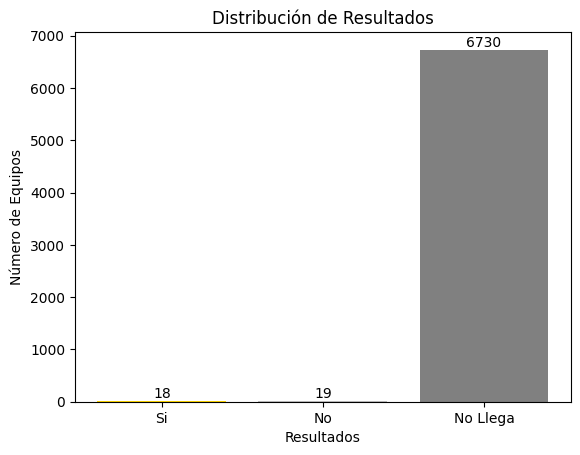

In [20]:
# Vamos a empezar con un gráfico donde se vea el % de campeones, de finalistas y de los que no llegan
# Calculo del total de equipos
total_equipos = len(March_Madness_df)

# Hacemos el conteo con categoria y creamos la lista para el gráfico
resultados = March_Madness_df['Is_Champion'].value_counts()
Categorias = ['Si', 'No', 'No Llega']

# Crear una lista de valores
valores = [resultados.get(Categoria, 0) for Categoria in Categorias]

# Generamos el gráfico con las barras en oro, plata y gris
plt.bar(Categorias, valores, color = ['gold','silver','gray'])

# Mostrar el numero total de cada categoria en el grafico
for i, v in enumerate(valores):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Título y Categorias de los ejes
plt.title('Distribución de Resultados')
plt.xlabel('Resultados')
plt.ylabel('Número de Equipos')

# Mostrar el gráfico
plt.show()

In [22]:
# Vamos a ver la tabla con las variables predictivas y la variable objetivo
pd.set_option('display.max_columns', None)
March_Madness_df[['Net Rating', 'AdjEM', 'Adjusted Offensive Efficiency', 'Adjusted Defensive Efficiency', 'eFGPct', 'FG2Pct', 'FG3Pct', 'BlockPct', 'OppFG2Pct',
                  'OppFG3Pct', 'OppBlockPct', 'EffectiveHeight', 'PGOR', 'PGDR', 'SGOR', 'SGDR', 'SFOR', 'SFDR', 'PFOR', 'PFDR', 'CenterOR', 'CenterDR', 'Bench', 'Is_Champion', 'Is_Champion_Num']].head(10)





,Net Rating,AdjEM,Adjusted Offensive Efficiency,Adjusted Defensive Efficiency,eFGPct,FG2Pct,FG3Pct,BlockPct,OppFG2Pct,OppFG3Pct,OppBlockPct,EffectiveHeight,PGOR,PGDR,SGOR,SGDR,SFOR,SFDR,PFOR,PFDR,CenterOR,CenterDR,Bench,Is_Champion,Is_Champion_Num
0,36.9,36.9118,121.3,84.4,0.515116,0.512117,0.348797,0.181633,0.391156,0.270898,0.059949,6.89,6.08,10.99,5.69,13.00,20.03,18.01,34.47,30.08,33.72,27.92,39.90,No Llega,0
1,36.5,36.4833,126.4,89.9,0.610178,0.638995,0.368098,0.069071,0.469685,0.327300,0.067784,0.65,11.41,19.49,22.61,24.63,6.54,13.28,19.89,18.56,39.47,23.99,24.27,No,1
2,36.4,36.4262,127.5,91.1,0.569075,0.591102,0.357518,0.141923,0.431655,0.312417,0.083333,1.53,14.05,15.33,13.83,20.55,20.29,20.98,18.66,17.21,33.13,25.88,28.14,Si,2
3,35.2,35.2083,120.9,85.7,0.565912,0.553672,0.396970,0.167407,0.411852,0.328162,0.063402,2.44,5.77,12.87,5.59,13.90,22.11,18.37,31.72,28.48,34.81,26.38,29.38,Si,2
4,34.2,34.2156,123.4,89.2,0.551800,0.525342,0.394834,0.129904,0.456844,0.288915,0.082864,1.18,8.61,13.59,8.82,17.84,14.67,18.51,30.03,26.61,37.86,23.45,22.86,Si,2
5,33.9,33.8670,125.0,91.1,0.565483,0.531842,0.412983,0.102873,0.487488,0.328597,0.105852,-0.56,5.21,11.65,7.14,16.34,15.00,14.23,39.18,27.69,33.47,30.09,28.57,Si,2
6,33.8,33.7197,129.0,95.2,0.547518,0.547925,0.364557,0.081725,0.446589,0.375465,0.063396,5.05,11.50,12.40,9.31,11.68,29.46,22.11,28.34,20.78,21.39,33.03,21.24,No,1
7,33.8,33.7563,127.8,94.0,0.595082,0.589704,0.400691,0.104990,0.489955,0.317016,0.081903,-0.43,4.45,13.94,9.99,17.28,19.54,19.99,27.17,19.16,38.82,29.62,25.88,Si,2
8,33.5,33.4687,125.0,91.5,0.563137,0.528520,0.422849,0.091261,0.468677,0.339678,0.085921,0.03,9.35,14.77,14.62,16.02,15.64,15.71,18.74,17.52,41.65,35.97,18.20,No Llega,0
9,33.3,33.2863,121.0,87.7,0.505270,0.469811,0.384910,0.098420,0.440462,0.282648,0.098113,4.88,7.41,9.76,6.17,13.36,21.55,19.76,23.77,23.46,41.10,33.66,23.41,Si,2


In [23]:
# Para el modelo predictivo, vamos a seleccionar las variables para la prediccion, son bastantes variables, pero nos va a ayudar a tener un análisis más preciso, y si fuese necesario, quitaremos inputs.
X = March_Madness_df[['Net Rating', 'AdjEM', 'Adjusted Offensive Efficiency', 'Adjusted Defensive Efficiency', 'eFGPct', 'FG2Pct', 'FG3Pct', 'BlockPct', 'OppFG2Pct', 'OppFG3Pct', 'OppBlockPct', 'EffectiveHeight', 'PGOR', 'PGDR', 'SGOR', 'SGDR', 'SFOR', 'SFDR', 'PFOR', 'PFDR', 'CenterOR', 'CenterDR', 'Bench']]
Y = March_Madness_df['Is_Champion_Num']
rs = 4477
test_size = 0.2
cv=5

# Separamos el modelo, y entrenamos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=rs)

#Escalado de los datos
Escalado = StandardScaler()
X_train_escal = Escalado.fit_transform(X_train)
X_test_escal = Escalado.transform(X_test)

print("Valores únicos en Y_train:", Y_train.unique())
print("Valores únicos en Y_test:", Y_test.unique())

# Aquí vemos el número de casos para el train y el test
print("Casos de Y train: ",len(Y_train))
print("Casos de Y test: ",len(Y_test))

# Vemos cuantos campeones y subcampeones hay en cada grupo
print("Casos de Y train: ",Y_train.value_counts())
print("Casos de Y test: ",Y_test.value_counts())

Valores únicos en Y_train: [0 1 2]
Valores únicos en Y_test: [0 1 2]
Casos de Y train:  5413
Casos de Y test:  1354
Casos de Y train:  Is_Champion_Num
0    5383
2      16
1      14
Name: count, dtype: int64
Casos de Y test:  Is_Champion_Num
0    1347
1       5
2       2
Name: count, dtype: int64


In [26]:
#Parametros y modelos
parameters = {
    'solver':['lbfgs', 'sag', 'saga', 'newton-cg','liblinear'],
    'multi_class':['ovr','multinomial'],
}
lr = LogisticRegression()
clf = GridSearchCV(lr,
                   param_grid=parameters,
                   scoring='precision',
                   cv=cv)
clf.fit(X_train, Y_train)
best_params_ = clf.best_params_
print(clf.best_params_)

{'multi_class': 'ovr', 'solver': 'lbfgs'}


<h1> 1. MODELO DE REGRESIÓN LOGÍSTICA</h1>

In [28]:
# Vamos a empezar con el modelo predicitivo de regresion logistica


modelo_logistico = LogisticRegression(multi_class=best_params_['multi_class'], solver='lbfgs',C=0.1,
                                      tol=1e-5, class_weight='balanced',penalty='l2',
                                      max_iter=2000)
modelo_logistico.fit(X_train_escal, Y_train)
Y_pred_logist = modelo_logistico.predict(X_test_escal)
accuracy_logist = accuracy_score(Y_test, Y_pred_logist)
print("Exactitud del modelo de regresión logística:", accuracy_logist)
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_logist))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_logist))
print("\nAccuracy Score:", accuracy_score(Y_test, Y_pred_logist))

scores = cross_val_score(modelo_logistico, X, Y, cv=cv)
print(scores)

Exactitud del modelo de regresión logística: 0.9180206794682423
Confusion Matrix:
 [[1239   24   84]
 [   2    3    0]
 [   0    1    1]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96      1347
           1       0.11      0.60      0.18         5
           2       0.01      0.50      0.02         2

    accuracy                           0.92      1354
   macro avg       0.37      0.67      0.39      1354
weighted avg       0.99      0.92      0.95      1354


Accuracy Score: 0.9180206794682423


In [42]:
# Hacemos ajustes y optimizamos hiperparametros
# Definimos los hiperparametros y rebalanceamos
C = 10
penalty = 'l2'
smote = SMOTE(sampling_strategy='minority', random_state=rs)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_escal, Y_train)

print("Distribución de clases en el conjunto de entrenamiento rebalanceado:")
print(Counter(Y_train_resampled))
# Verifica las dimensiones
print(f"Dimensiones de X_train_resampled: {X_train_resampled.shape}")
print(f"Dimensiones de Y_train_resampled: {Y_train_resampled.shape}")

Distribución de clases en el conjunto de entrenamiento rebalanceado:
Counter({0: 5383, 1: 5383, 2: 16})
Dimensiones de X_train_resampled: (10782, 23)
Dimensiones de Y_train_resampled: (10782,)


In [44]:
#Modelo con los ajustes hechos
modelo_logistico_v2 = LogisticRegression(multi_class=best_params_['multi_class'], solver=best_params_['solver'], C=C, penalty = penalty, class_weight='balanced', max_iter=1000)
modelo_logistico_v2.fit(X_train_resampled, Y_train_resampled)
Y_pred_logist = modelo_logistico_v2.predict(X_test_escal)
accuracy_logist = accuracy_score(Y_test, Y_pred_logist)
print("Exactitud del modelo de regresión logística:", accuracy_logist)
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_logist))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_logist))
print("\nAccuracy Score:", accuracy_score(Y_test, Y_pred_logist))
scores = cross_val_score(modelo_logistico, X, Y, cv=cv)
print(scores)

Exactitud del modelo de regresión logística: 0.9793205317577548
Confusion Matrix:
 [[1322   18    7]
 [   2    3    0]
 [   1    0    1]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1347
           1       0.14      0.60      0.23         5
           2       0.12      0.50      0.20         2

    accuracy                           0.98      1354
   macro avg       0.42      0.69      0.47      1354
weighted avg       0.99      0.98      0.99      1354


Accuracy Score: 0.9793205317577548
[0.44608567 0.89143279 0.98447894 0.99113082 0.99556541]


<h1>2. Decision tree</h1>

In [121]:
# Vamos ahora con arboles de decision
decision_tree = DecisionTreeClassifier(class_weight = 'balanced',random_state=rs)
decision_tree.fit(X_train_escal, Y_train)
Y_pred_dt = decision_tree.predict(X_test_escal)
accuracy = accuracy_score(Y_test, Y_pred_dt)
conf_matrix = confusion_matrix(Y_test, Y_pred_dt)
class_report = classification_report(Y_test, Y_pred_dt)

print("Exactitud del modelo de árboles de decisión:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
cv_scores_dt = cross_val_score(decision_tree, X, Y, cv=5)
print("Cross-Validation Scores:", cv_scores_dt)
print("Mean CV Score:", cv_scores_dt.mean())

Exactitud del modelo de árboles de decisión: 0.9903988183161004
Confusion Matrix:
 [[1340    4    3]
 [   3    1    1]
 [   2    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1347
           1       0.20      0.20      0.20         5
           2       0.00      0.00      0.00         2

    accuracy                           0.99      1354
   macro avg       0.40      0.40      0.40      1354
weighted avg       0.99      0.99      0.99      1354

Cross-Validation Scores: [0.27917282 0.99630724 0.99556541 0.99334812 0.99482631]
Mean CV Score: 0.8518439792965138


<h1>2. MODELO RANDOM FOREST</h1>

In [112]:
# Creamos el modelo Random Forest
RFor = RandomForestClassifier(n_estimators=300, class_weight = 'balanced', random_state=rs)

# Ajustar el modelo a los datos de entrenamiento
RFor.fit(X_train_escal, Y_train)

# Realizar predicciones en los datos de prueba
Y_pred_rf = RFor.predict(X_test_escal)

# Evaluar el modelo
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
print("Exactitud del modelo Random Forest:", accuracy_rf)
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_rf))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_rf))


Exactitud del modelo Random Forest: 0.9948301329394387
Confusion Matrix:
 [[1347    0    0]
 [   5    0    0]
 [   2    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1347
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         2

    accuracy                           0.99      1354
   macro avg       0.33      0.33      0.33      1354
weighted avg       0.99      0.99      0.99      1354



In [117]:
# Creamos el modelo Random Forest v2
RFor_v2 = RandomForestClassifier(n_estimators=600, class_weight= 'balanced_subsample',max_depth=5,
                              min_samples_split=10, min_samples_leaf=2,
                              random_state=rs, bootstrap=False)

# Ajustar el modelo a los datos de entrenamiento
RFor_v2.fit(X_train_resampled, Y_train_resampled)

# Realizar predicciones en los datos de prueba
Y_pred_rf = RFor_v2.predict(X_test_escal)

# Evaluar el modelo
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
print("Exactitud del modelo Random Forest:", accuracy_rf)
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_rf))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_rf))

# Aplicar validación cruzada al modelo Random Forest
cv_scores = cross_val_score(RFor_v2, X, Y, cv=cv, scoring='accuracy')

print("Puntuaciones de Exactitud en cada partición de la validación cruzada:", cv_scores)
print("Promedio de Exactitud:", cv_scores.mean())
print("Desviación Estándar de la Exactitud:", cv_scores.std())

Exactitud del modelo Random Forest: 0.96602658788774
Confusion Matrix:
 [[1303   42    2]
 [   1    4    0]
 [   0    1    1]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      1347
           1       0.09      0.80      0.15         5
           2       0.33      0.50      0.40         2

    accuracy                           0.97      1354
   macro avg       0.47      0.76      0.51      1354
weighted avg       0.99      0.97      0.98      1354

Puntuaciones de Exactitud en cada partición de la validación cruzada: [0.33456425 0.99778434 0.99704361 0.99704361 0.99556541]
Promedio de Exactitud: 0.8644002441098669
Desviación Estándar de la Exactitud: 0.26491897562470806


In [118]:
#Vamos a probar algo distinto a Smote, vamos a aplicar adasyn y luego smote sobre estos
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy='minority', random_state=rs)
X_train_resampled_v2, Y_train_resampled_v2 = adasyn.fit_resample(X_train_escal, Y_train)

smote_adasyn = SMOTE(sampling_strategy='minority', random_state=rs)
X_train_resampled_v3, Y_train_resampled_v3 = smote_adasyn.fit_resample(X_train_resampled_v2, Y_train_resampled_v2)

# Vamos a mejorar el modelo Random Forest
RFor_v2 = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample',max_depth=3,
                              min_samples_split=10, min_samples_leaf=2,
                              random_state=rs,bootstrap=False)

# Ajustar el modelo a los datos de entrenamiento
RFor_v2.fit(X_train_resampled_v3, Y_train_resampled_v3)

# Realizar predicciones en los datos de prueba
Y_pred_rf = RFor_v2.predict(X_test_escal)

# Evaluar el modelo
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
print("Exactitud del modelo Random Forest:", accuracy_rf)
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_rf))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_rf))

# Este modelo no mejora lo que tenemos con el paso anterior

Exactitud del modelo Random Forest: 0.9549483013293943
Confusion Matrix:
 [[1289   46   12]
 [   1    2    2]
 [   0    0    2]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      1347
           1       0.04      0.40      0.08         5
           2       0.12      1.00      0.22         2

    accuracy                           0.95      1354
   macro avg       0.39      0.79      0.43      1354
weighted avg       0.99      0.95      0.97      1354



<h1>Prueba de Random Forest Balanced</h1>

In [125]:
# Crear el modelo Random Forest
RForB = BalancedRandomForestClassifier(n_estimators=300, class_weight = 'balanced_subsample', random_state=rs)

# Ajustar el modelo a los datos de entrenamiento
RFor.fit(X_train_escal, Y_train)

# Realizar predicciones en los datos de prueba
Y_pred_rf = RFor.predict(X_test_escal)

# Evaluar el modelo
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
print("Exactitud del modelo Random Forest:", accuracy_rf)
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_rf))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_rf))

Exactitud del modelo Random Forest: 0.9948301329394387
Confusion Matrix:
 [[1347    0    0]
 [   5    0    0]
 [   2    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1347
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         2

    accuracy                           0.99      1354
   macro avg       0.33      0.33      0.33      1354
weighted avg       0.99      0.99      0.99      1354



In [139]:
# Crear el modelo Random Forest
RForB_v2 = BalancedRandomForestClassifier(n_estimators=400,
                              random_state=rs, bootstrap=False)

# Ajustar el modelo a los datos de entrenamiento
RForB_v2.fit(X_train_resampled, Y_train_resampled)

# Realizar predicciones en los datos de prueba
Y_pred_rf = RForB_v2.predict(X_test_escal)

# Evaluar el modelo
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
print("Exactitud del modelo Random Forest:", accuracy_rf)
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_rf))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_rf))

# Aplicar validación cruzada al modelo Random Forest
cv_scores = cross_val_score(RForB_v2, X, Y, cv=cv, scoring='accuracy')

print("Puntuaciones de Exactitud en cada partición de la validación cruzada:", cv_scores)
print("Promedio de Exactitud:", cv_scores.mean())
print("Desviación Estándar de la Exactitud:", cv_scores.std())


# No mejora el Random Forest ajustado tampoco

Exactitud del modelo Random Forest: 0.946824224519941
Confusion Matrix:
 [[1278   51   18]
 [   1    2    2]
 [   0    0    2]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      1347
           1       0.04      0.40      0.07         5
           2       0.09      1.00      0.17         2

    accuracy                           0.95      1354
   macro avg       0.38      0.78      0.40      1354
weighted avg       0.99      0.95      0.97      1354

Puntuaciones de Exactitud en cada partición de la validación cruzada: [0.19645495 0.99704579 0.99778271 0.99778271 0.99556541]
Promedio de Exactitud: 0.8369263117903103
Desviación Estándar de la Exactitud: 0.3202367052394685


<h1>4. Modelo de Redes neuronales</h1>

In [203]:
#Revisamos ahora el modelo predictivo con redes neuronales

# Definimos el modelo secuencial de redes neuronales
redes_neuronales = tf.keras.models.Sequential()

# Añadimos las capas
redes_neuronales.add(layers.Dense(64, activation='relu', input_shape=(X_train_escal.shape[1],)))
redes_neuronales.add(layers.Dense(128, activation='relu'))
redes_neuronales.add(layers.Dense(64, activation='relu'))

# Capa de salida con softmax para clasificación multiclase
redes_neuronales.add(layers.Dense(3, activation='softmax'))

# Resumen de la arquitectura de la red neuronal
redes_neuronales.summary()



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                     │ (None, 64)                  │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,307 (71.51 KB)

 Trainable params: 18,307 (71.51 KB)

 Non-trainable params: 0 (0.00 B)

In [204]:
# Compilamos el modelo
redes_neuronales.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
redes_neuronales.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                     │ (None, 64)                  │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,307 (71.51 KB)

 Trainable params: 18,307 (71.51 KB)

 Non-trainable params: 0 (0.00 B)

In [205]:
# Convertimos las etiquetas a formato one-hot encoding
Y_train_one_hot = to_categorical(Y_train, num_classes=3)
Y_test_one_hot = to_categorical(Y_test, num_classes=3)

print("Valores únicos en Y_train_one_hot:\n", np.unique(Y_train_one_hot, axis=0))
print("Valores únicos en Y_test_one_hot:\n", np.unique(Y_test_one_hot, axis=0))

Valores únicos en Y_train_one_hot:
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
Valores únicos en Y_test_one_hot:
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [199]:
print(np.shape(X_test_escal))
print(np.shape(Y_test_one_hot))

(1354, 23)
(1354, 3)


In [209]:
# Mostrar el conteo
conteo_categorias = Y_test.value_counts()
print(conteo_categorias)

Is_Champion_Num
0    1347
1       5
2       2
Name: count, dtype: int64


In [210]:
history = redes_neuronales.fit(X_train, Y_train_one_hot, epochs=10, batch_size=64,
                               shuffle=True, validation_data=(X_test_escal, Y_test_one_hot))



Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8088 - loss: 3.6549 - val_accuracy: 0.6078 - val_loss: 0.9871
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0578 - val_accuracy: 0.4956 - val_loss: 1.0904
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9932 - loss: 0.0236 - val_accuracy: 0.5222 - val_loss: 1.0606
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9961 - loss: 0.0215 - val_accuracy: 0.5406 - val_loss: 1.0373
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9941 - loss: 0.0234 - val_accuracy: 0.6233 - val_loss: 0.9808
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9931 - loss: 0.0277 - val_accuracy: 0.5945 - val_loss: 1.0136
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0232 - val_accuracy: 0.6514 - val_loss: 0.9710
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9942 - loss: 0.0216 - val_accuracy: 0.6935 - val_loss:

In [211]:
resultados = redes_neuronales.evaluate(X_test, Y_test_one_hot)
print("Pérdida en el conjunto de prueba:", resultados[0])
print("Precisión en el conjunto de prueba:", resultados[1])

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9958 - loss: 0.0215 
Pérdida en el conjunto de prueba: 0.02824629843235016
Precisión en el conjunto de prueba: 0.9948301315307617


In [217]:
# Obtener las predicciones en el conjunto de prueba
Y_pred_rn = redes_neuronales.predict(X_test_escal)
Y_pred_rn_classes = np.argmax(Y_pred_rn, axis=1)  # Convertir probabilidades a clases

# Evaluar el rendimiento
conf_matrix_rn = confusion_matrix(Y_test, Y_pred_rn_classes)
class_report_rn = classification_report(Y_test, Y_pred_rn_classes)

# Mostrar resultados
print("Confusion Matrix:\n", conf_matrix_rn)
print("\nClassification Report:\n", class_report_rn)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:
 [[891 170 286]
 [  0   2   3]
 [  0   1   1]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.66      0.80      1347
           1       0.01      0.40      0.02         5
           2       0.00      0.50      0.01         2

    accuracy                           0.66      1354
   macro avg       0.34      0.52      0.28      1354
weighted avg       0.99      0.66      0.79      1354



In [219]:
df = pd.DataFrame(X_train_escal)
df['target'] = Y_train
correlation_matrix = df.corr()
x=correlation_matrix['target']

y=(abs(x)>=0.009 )
#print(y)
df_filtered = y[y == True]
indices=df_filtered.index[0:-1]
print(indices)
df = pd.DataFrame(X_train_escal)
df_filtrado = df[indices]
print(df_filtrado)

Index([0, 1, 2, 3, 4, 6, 7, 17, 18, 19, 20, 21], dtype='object')
            0         1         2         3         4         6         7   \
0    -1.084668 -1.081812 -1.605532  0.178766 -0.872457 -0.561320 -1.008822   
1     0.739832  0.741934 -0.015468 -1.396316  0.002805  0.227491 -0.362842   
2    -0.967499 -0.964486 -0.776525  0.911725 -0.754997 -0.265413 -0.432298   
3    -1.093038 -1.097328 -0.790115  1.130054  0.379627 -0.389239  0.231344   
4    -0.038510 -0.038395 -0.164961 -0.117536  0.555425 -0.080492  0.565529   
...        ...       ...       ...       ...       ...       ...       ...   
5408  1.409374  1.406453  1.248429 -1.193583  0.503095 -0.633444 -0.017150   
5409 -1.461285 -1.460656 -1.510400  0.989700 -1.024100 -1.160760 -1.202171   
5410 -2.390274 -2.388968 -2.407360  1.691469 -2.772039 -2.420338 -0.774089   
5411 -1.218577 -1.219575 -0.735754  1.426356 -0.431931  0.270231 -1.425989   
5412  0.078660  0.078966 -0.463948 -0.678952  0.000085  0.042781 -0.678000   

In [220]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = dict(enumerate(class_weights))
redes_neuronales.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = redes_neuronales.fit(X_train_escal, Y_train_one_hot, epochs=10, batch_size=64, validation_split=0.2, class_weight=class_weights_dict)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8343 - loss: 1.3034 - val_accuracy: 0.9141 - val_loss: 0.2429
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9016 - loss: 0.8842 - val_accuracy: 0.8994 - val_loss: 0.2775
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9182 - loss: 0.5189 - val_accuracy: 0.9012 - val_loss: 0.2831
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9339 - loss: 0.4708 - val_accuracy: 0.9224 - val_loss: 0.2176
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9396 - loss: 0.3540 - val_accuracy: 0.9215 - val_loss: 0.2286
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9418 - loss: 0.3074 - val_accuracy: 0.9335 - val_loss: 0.1857
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9472 - loss: 0.1688 - val_accuracy: 0.9621 - val_loss: 0.1136
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9583 - loss: 0.1194 - val_accuracy: 0.9612 - val_loss

In [221]:
# Vamos a evaluarlo
resultados = redes_neuronales.evaluate(X_test_escal, Y_test_one_hot)
print("Pérdida en el conjunto de prueba:", resultados[0])
print("Precisión en el conjunto de prueba:", resultados[1])

# Obtener las predicciones en el conjunto de prueba
Y_pred_rn = redes_neuronales.predict(X_test_escal)
Y_pred_rn_classes = np.argmax(Y_pred_rn, axis=1)  # Convertir probabilidades a clases

# Evaluar el rendimiento
conf_matrix_rn = confusion_matrix(Y_test, Y_pred_rn_classes)
class_report_rn = classification_report(Y_test, Y_pred_rn_classes)

# Mostrar resultados
print("Confusion Matrix:\n", conf_matrix_rn)
print("\nClassification Report:\n", class_report_rn)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9732 - loss: 0.0921
Pérdida en el conjunto de prueba: 0.1234516128897667
Precisión en el conjunto de prueba: 0.9615952968597412
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix:
 [[1301   37    9]
 [   4    1    0]
 [   2    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      1347
           1       0.03      0.20      0.05         5
           2       0.00      0.00      0.00         2

    accuracy                           0.96      1354
   macro avg       0.34      0.39      0.34      1354
weighted avg       0.99      0.96      0.98      1354



In [224]:
#Revisamos ahora el modelo predictivo con redes neuronales, y vemos como ajustarlo

# Definimos el modelo secuencial de redes neuronales
redes_neuronales_v2 = tf.keras.models.Sequential()

# Añadimos las capas
redes_neuronales_v2.add(layers.Dense(32, activation='relu', input_shape=(X_train_escal.shape[1],)))
redes_neuronales_v2.add(layers.Dropout(0.5))
redes_neuronales_v2.add(layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
redes_neuronales_v2.add(layers.Dropout(0.5))
redes_neuronales_v2.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
redes_neuronales_v2.add(layers.Dropout(0.5))
redes_neuronales_v2.add(layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

# Capa de salida con softmax para clasificación multiclase
redes_neuronales_v2.add(layers.Dense(3, activation='softmax'))

# Resumen de la arquitectura de la red neuronal
redes_neuronales_v2.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                     │ (None, 32)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,219 (36.01 KB)

 Trainable params: 9,219 (36.01 KB)

 Non-trainable params: 0 (0.00 B)

In [225]:
# Compilamos el modelo
optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001)
redes_neuronales_v2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
redes_neuronales_v2.summary()

# Convertimos las etiquetas a formato one-hot encoding
Y_train_one_hot = to_categorical(Y_train_resampled_v3, num_classes=3)
Y_test_one_hot = to_categorical(Y_test, num_classes=3)

print("Valores únicos en Y_train_one_hot:\n", np.unique(Y_train_one_hot, axis=0))
print("Valores únicos en Y_test_one_hot:\n", np.unique(Y_test_one_hot, axis=0))

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                     │ (None, 32)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,219 (36.01 KB)

 Trainable params: 9,219 (36.01 KB)

 Non-trainable params: 0 (0.00 B)

Valores únicos en Y_train_one_hot:
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
Valores únicos en Y_test_one_hot:
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [231]:
# Compilamos el modelo
redes_neuronales_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo con las etiquetas en formato one-hot
history = redes_neuronales_v2.fit(X_train_resampled_v3, Y_train_one_hot, epochs=200, batch_size=64, class_weight = {0:1, 1: 10000, 2: 10000}, validation_data=(X_test_escal, Y_test_one_hot))

Epoch 1/200
253/253 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9545 - loss: 4.6394 - val_accuracy: 0.9321 - val_loss: 1.5381
Epoch 2/200
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9326 - loss: 59.1977 - val_accuracy: 0.9003 - val_loss: 1.5091
Epoch 3/200
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8917 - loss: 19.1111 - val_accuracy: 0.9276 - val_loss: 1.4251
Epoch 4/200
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9000 - loss: 17.2299 - val_accuracy: 0.9217 - val_loss: 1.4323
Epoch 5/200
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9242 - loss: 6.1711 - val_accuracy: 0.0968 - val_loss: 4.9576
Epoch 6/200
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8776 - loss: 10.1661 - val_accuracy: 0.9018 - val_loss: 1.9260
Epoch 7/200
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9244 - loss: 12.4391 - val_accuracy: 0.9261 - val_loss: 1.5730
Epoch 8/200
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9257 - loss: 9.9749 - val

In [232]:
resultados = redes_neuronales_v2.evaluate(X_test_escal, Y_test_one_hot)
print("Pérdida en el conjunto de prueba:", resultados[0])
print("Precisión en el conjunto de prueba:", resultados[1])

# Obtener las predicciones en el conjunto de prueba
Y_pred_rn = redes_neuronales_v2.predict(X_test_escal)
Y_pred_rn_classes = np.argmax(Y_pred_rn, axis=1)  # Convertir probabilidades a clases

# Evaluar el rendimiento
conf_matrix_rn = confusion_matrix(Y_test, Y_pred_rn_classes)
class_report_rn = classification_report(Y_test, Y_pred_rn_classes)

# Mostrar resultados
print("Confusion Matrix:\n", conf_matrix_rn)
print("\nClassification Report:\n", class_report_rn)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8789 - loss: 1.9869
Pérdida en el conjunto de prueba: 2.147001028060913
Precisión en el conjunto de prueba: 0.8729689717292786
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix:
 [[1179   10  158]
 [   4    1    0]
 [   0    0    2]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93      1347
           1       0.09      0.20      0.13         5
           2       0.01      1.00      0.02         2

    accuracy                           0.87      1354
   macro avg       0.37      0.69      0.36      1354
weighted avg       0.99      0.87      0.93      1354

